In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_model_name, last_tune_log, tune, Verbosity
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "022"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [ ]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 300  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50  # 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32  # 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 64  # 8
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

In [6]:
import os
from pathlib import Path
import shutil


def symlink_shm(relative_path: str) -> bool:
    if not Path("/dev/shm").exists():
        return False

    output_dir = Path(relative_path).absolute()
    if output_dir.is_symlink():
        return True

    os.makedirs(output_dir.parent, exist_ok=True)
    # Create corresponding path in /dev/shm by using the relative parts
    shm_dir = Path("/dev/shm").joinpath(*Path(relative_path).parts)

    if output_dir.exists():
        # copy output_dir to shm_dir
        shutil.copytree(output_dir, shm_dir)
        # delete output_dir
        shutil.rmtree(output_dir)
    else:
        os.makedirs(shm_dir, exist_ok=True)
    os.symlink(shm_dir, output_dir, target_is_directory=True)
    return True


symlink_shm(output_dir)

True

In [ ]:
chat_template = """{{bos_token}}
{%- for message in messages -%}
    {{'<|im_start|>' + message['role'] + '\n'}}{% if message['role'] == 'assistant' %}{% generation %}{{ message['content'] }}{% endgeneration %}{% else %}{{ message['content'] }}{% endif %}{{'<|im_end|>' + '\n'}}
{%- endfor -%}
{%- if add_generation_prompt -%}
    {{ '<|im_start|>assistant\n' }}
{%- endif -%}"""

In [11]:
tokenizer.get_chat_template().replace(
    "{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}",
    "{{'<|im_start|>' + message['role'] + '\n'}}{% if message['role'] == 'assistant' %}{% generation %}{{ message['content'] }}{% endgeneration %}{% else %}{{ message['content'] }}{% endif %}{{'<|im_end|>' + '\n'}}",
)

"{{bos_token}}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n'}}{% if message['role'] == 'assistant' %}{% generation %}{{ message['content'] }}{% endgeneration %}{% else %}{{ message['content'] }}{% endif %}{{'<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

In [ ]:
print("{{bos_token}}{% for message in messages %}{% if message['role'] == 'assistant' %}{{'<|im_start|>' + message['role'] + '\n}}{% generation %}{{ message['content'] }}{% endgeneration %}{{ '<|im_end|>\n' }}{% else %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}")

In [10]:
tokenizer.get_chat_template()

"{{bos_token}}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

In [ ]:
"{{bos_token}}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n'}}{% if message['role'] == 'assistant' %}{% generation %}{{ message['content'] }}{% endgeneration %}{{'<|im_end|>' + '\n'}}{% else %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

In [30]:
4096 * 2

8192

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0001 --port=8001 --api-key=default
INFO 02-20 18:21:16 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:21:17 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:21:17 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0001', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.32s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.32s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.66s/it]



INFO 02-20 18:21:39 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:21:40 worker.py:267] Memory profiling takes 0.98 seconds
INFO 02-20 18:21:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:21:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:21:40 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:21:40 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:22:28 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.55 seconds
INFO 02-20 18:22:28 api_server.py:756] Using supplied chat template:
INFO 02-20 18:22:28 api_server.py:756] None
INFO 02-20 18:22:28 launcher.py:21] Available routes are:
INFO 02-20 18:22:28 launcher.py:29] Route: /

INFO:     Started server process [51526]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:22:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-20 18:22:36 metrics.py:455] Avg prompt throughput: 1.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-20 18:22:36 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:37450 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

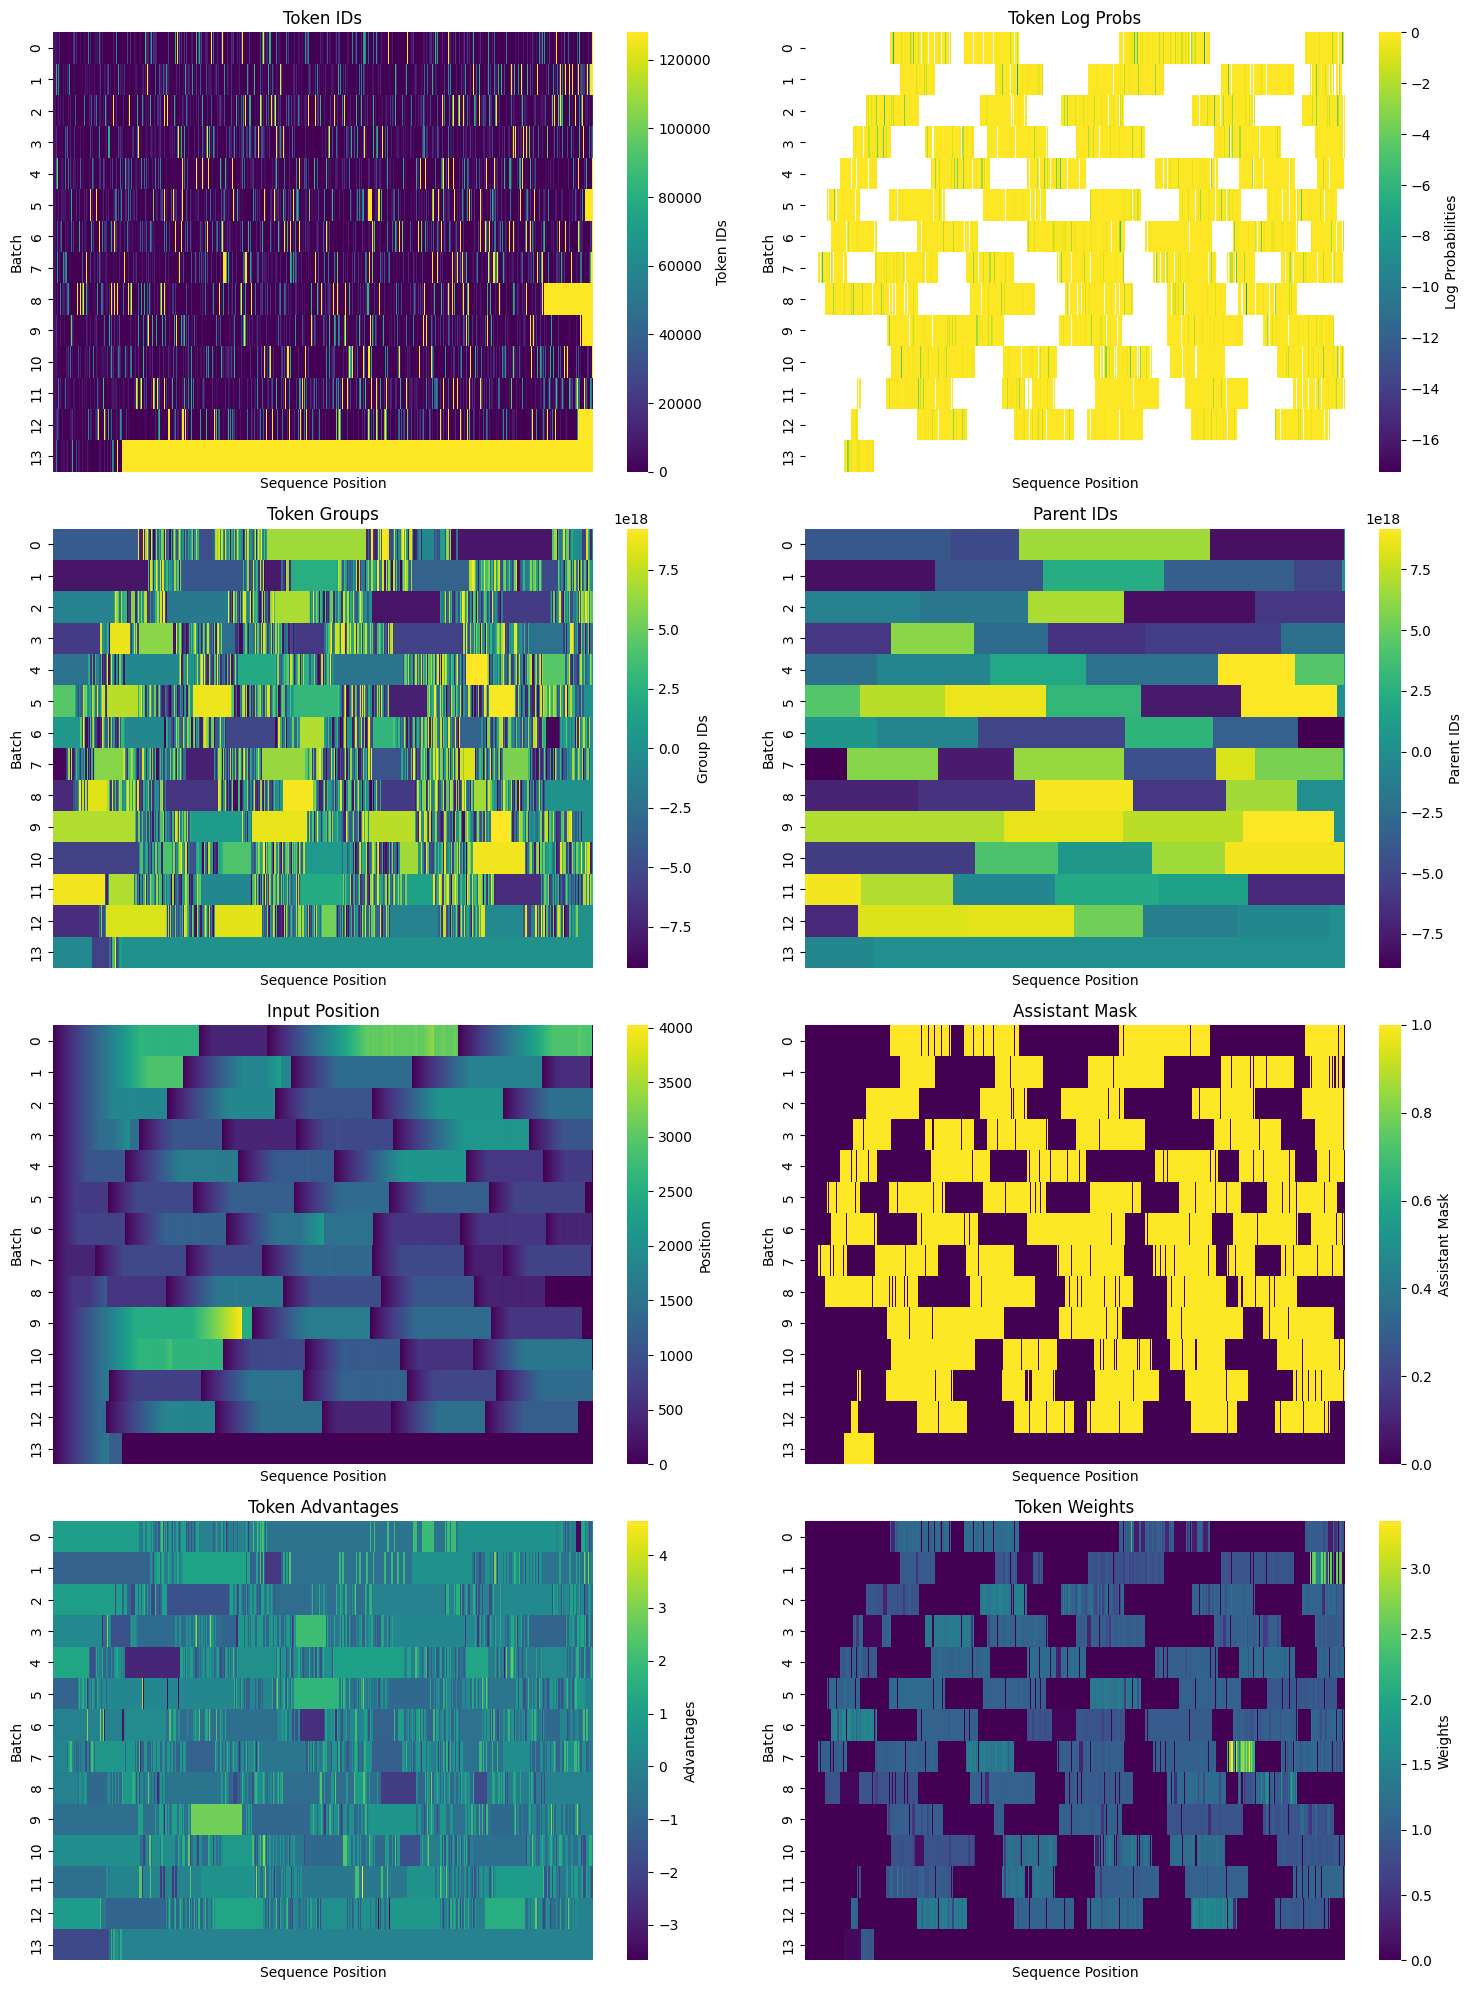

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0001
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 14
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740075902.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.49 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|7|Loss: -0.0135: 100%|██████████| 7/7 [02:31<00:00, 20.50s/it, entropy=0.12, kl_div=nan, loss=-0.0135, policy=-0.0135] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.95 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #2 model files to ./models/022/0002
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0002 --port=8001 --api-key=default
INFO 02-20 18:28:29 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:28:30 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:28:30 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0002', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.29s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.29s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.25s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.27s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.64s/it]



INFO 02-20 18:28:52 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:28:53 worker.py:267] Memory profiling takes 0.91 seconds
INFO 02-20 18:28:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:28:53 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:28:53 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:28:53 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:29:41 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.70 seconds
INFO 02-20 18:29:42 api_server.py:756] Using supplied chat template:
INFO 02-20 18:29:42 api_server.py:756] None
INFO 02-20 18:29:42 launcher.py:21] Available routes are:
INFO 02-20 18:29:42 launcher.py:29] Route: /

INFO:     Started server process [55222]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:29:45 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53882 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0001


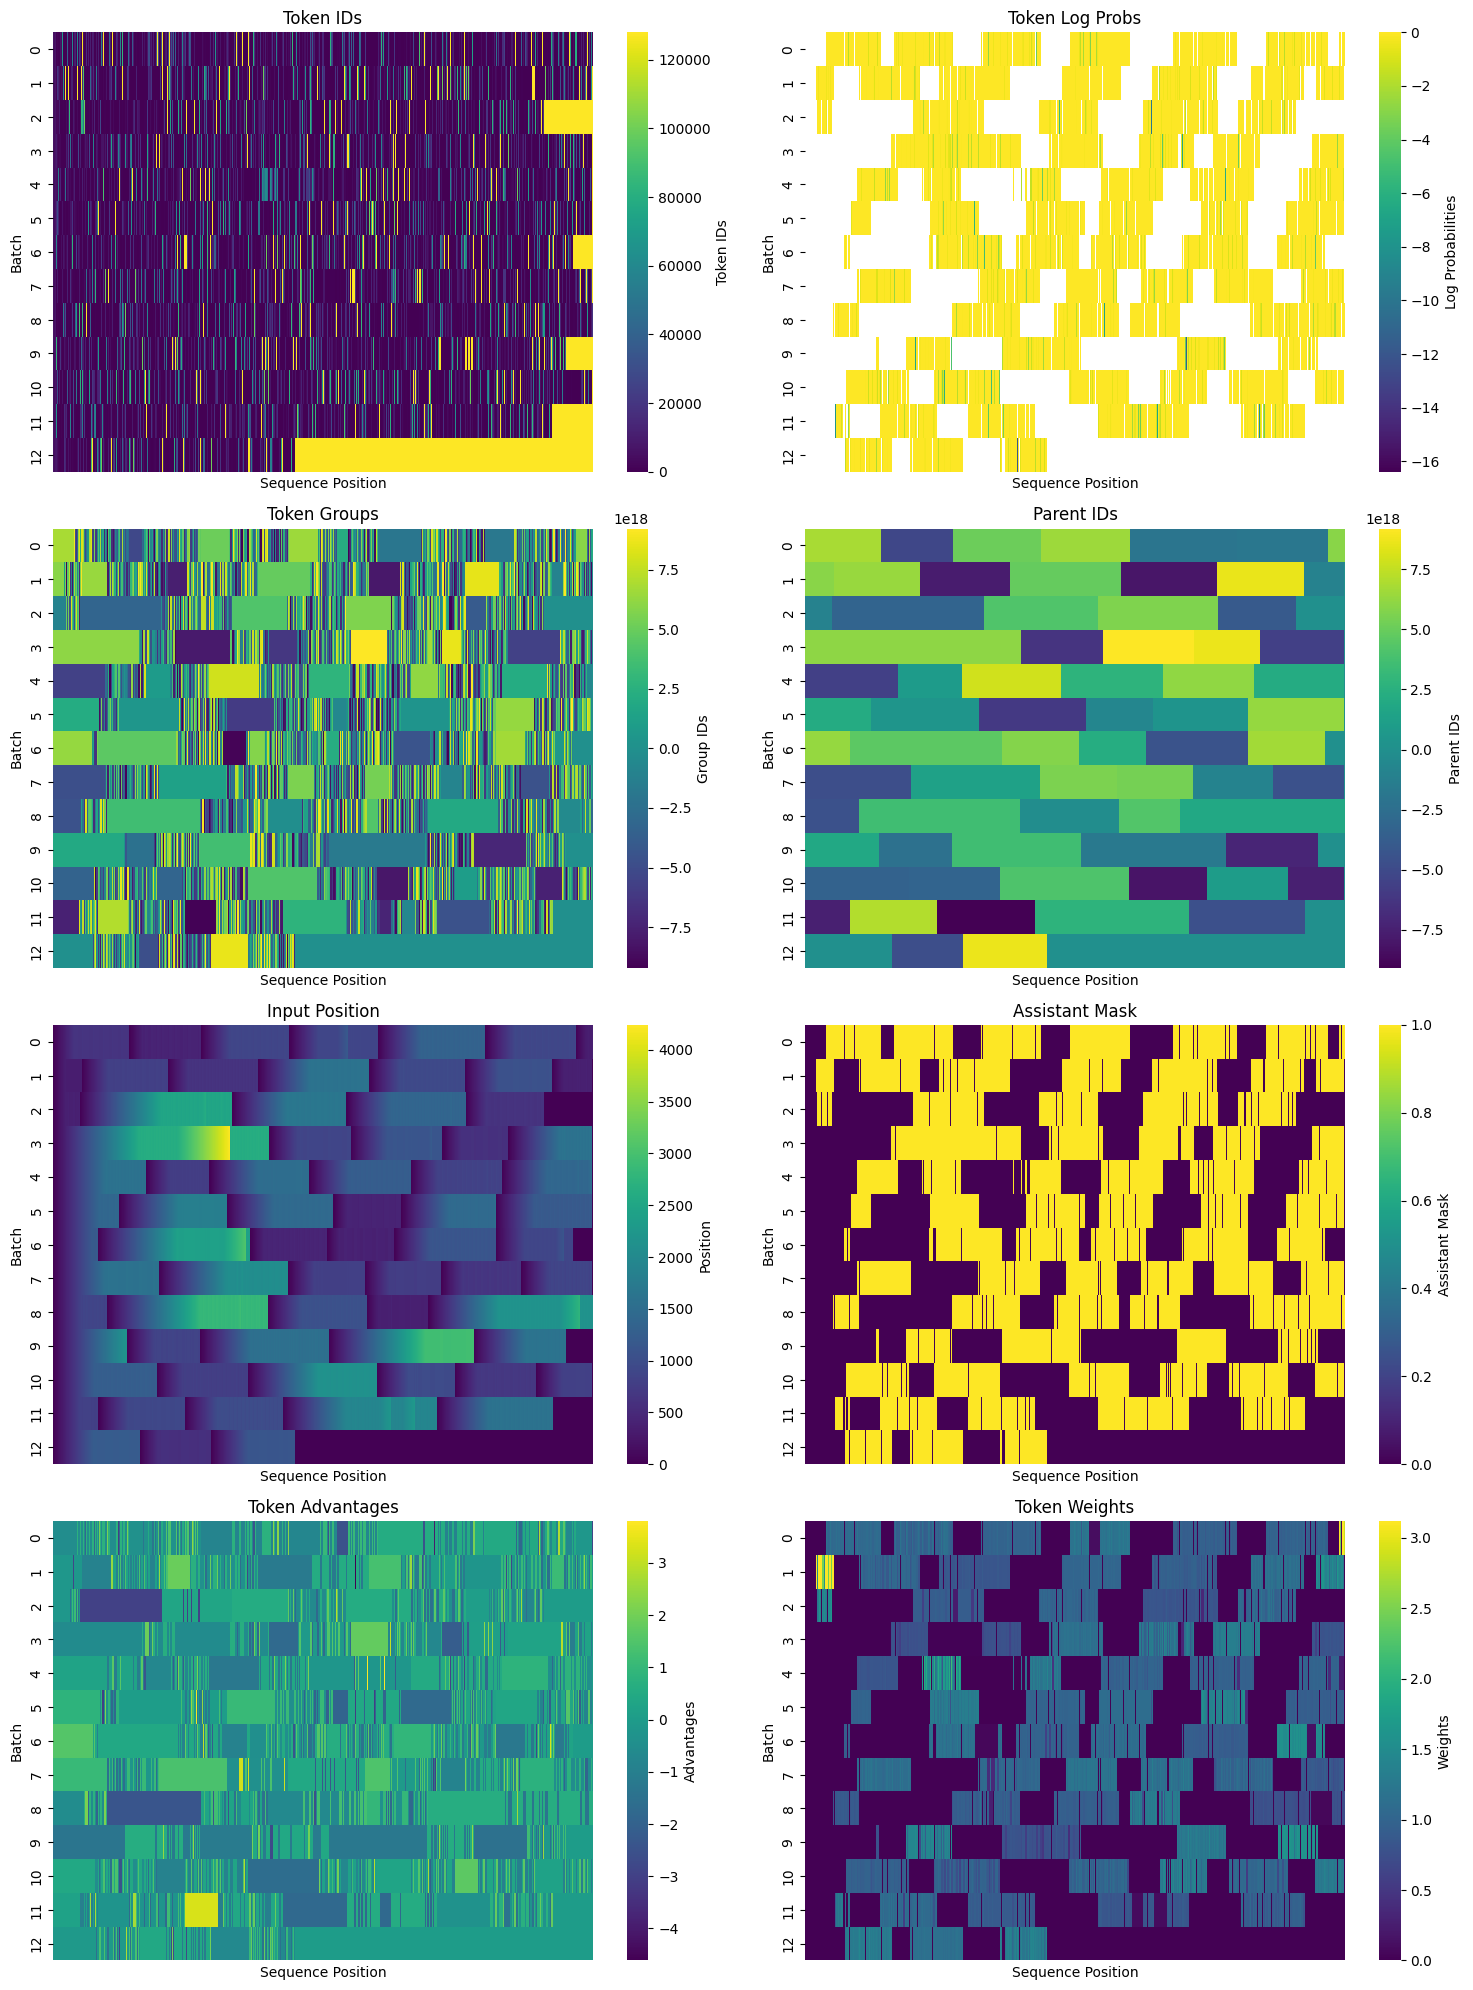

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0002
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740076317.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.48 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0006: 100%|██████████| 6/6 [02:11<00:00, 20.75s/it, entropy=0.0803, kl_div=nan, loss=-0.000582, policy=-0.000582]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.00 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #3 model files to ./models/022/0003
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0003 --port=8001 --api-key=default
INFO 02-20 18:35:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:35:04 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:35:04 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0003', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.27s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.24s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.26s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.62s/it]



INFO 02-20 18:35:26 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:35:27 worker.py:267] Memory profiling takes 0.94 seconds
INFO 02-20 18:35:27 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:35:27 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:35:27 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:35:27 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:36:14 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.26 seconds
INFO 02-20 18:36:15 api_server.py:756] Using supplied chat template:
INFO 02-20 18:36:15 api_server.py:756] None
INFO 02-20 18:36:15 launcher.py:21] Available routes are:
INFO 02-20 18:36:15 launcher.py:29] Route: /

INFO:     Started server process [58541]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:36:19 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48442 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0002


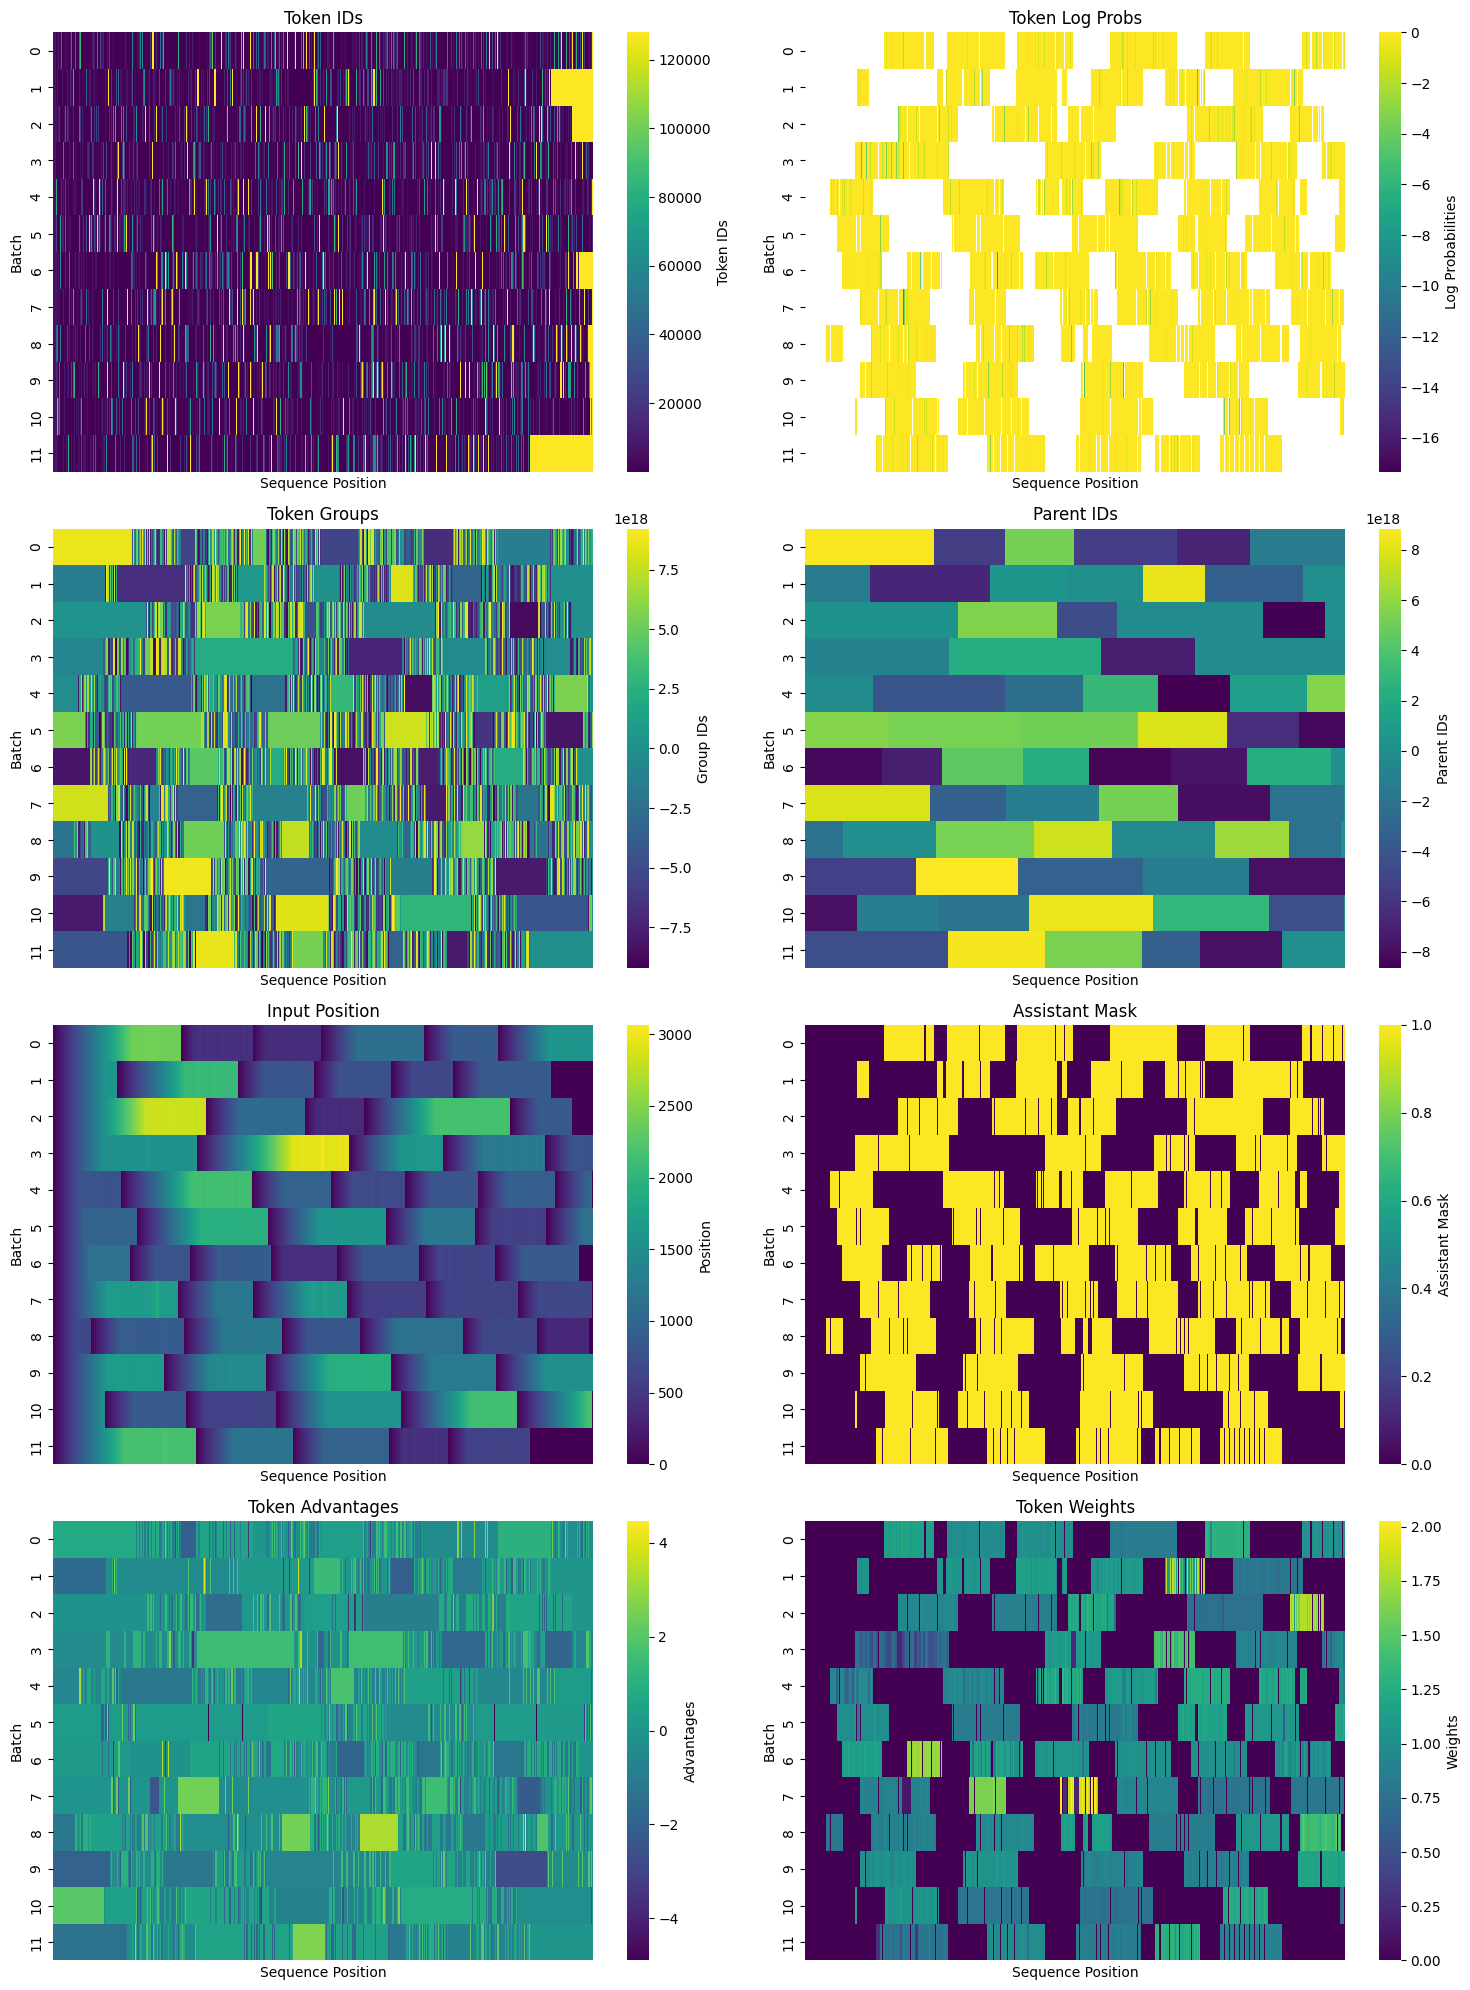

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0003
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 12
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740076705.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.52 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: 0.0011: 100%|██████████| 6/6 [02:11<00:00, 20.80s/it, entropy=0.086, kl_div=nan, loss=0.00105, policy=0.00105]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.88 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #4 model files to ./models/022/0004
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0004 --port=8001 --api-key=default
INFO 02-20 18:41:32 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:41:33 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:41:33 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0004', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.29s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.29s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.26s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.25s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.63s/it]



INFO 02-20 18:41:55 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:41:56 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-20 18:41:56 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:41:56 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:41:56 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:41:56 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:42:43 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.97 seconds
INFO 02-20 18:42:44 api_server.py:756] Using supplied chat template:
INFO 02-20 18:42:44 api_server.py:756] None
INFO 02-20 18:42:44 launcher.py:21] Available routes are:
INFO 02-20 18:42:44 launcher.py:29] Route: /

INFO:     Started server process [61496]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:42:45 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44298 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0003


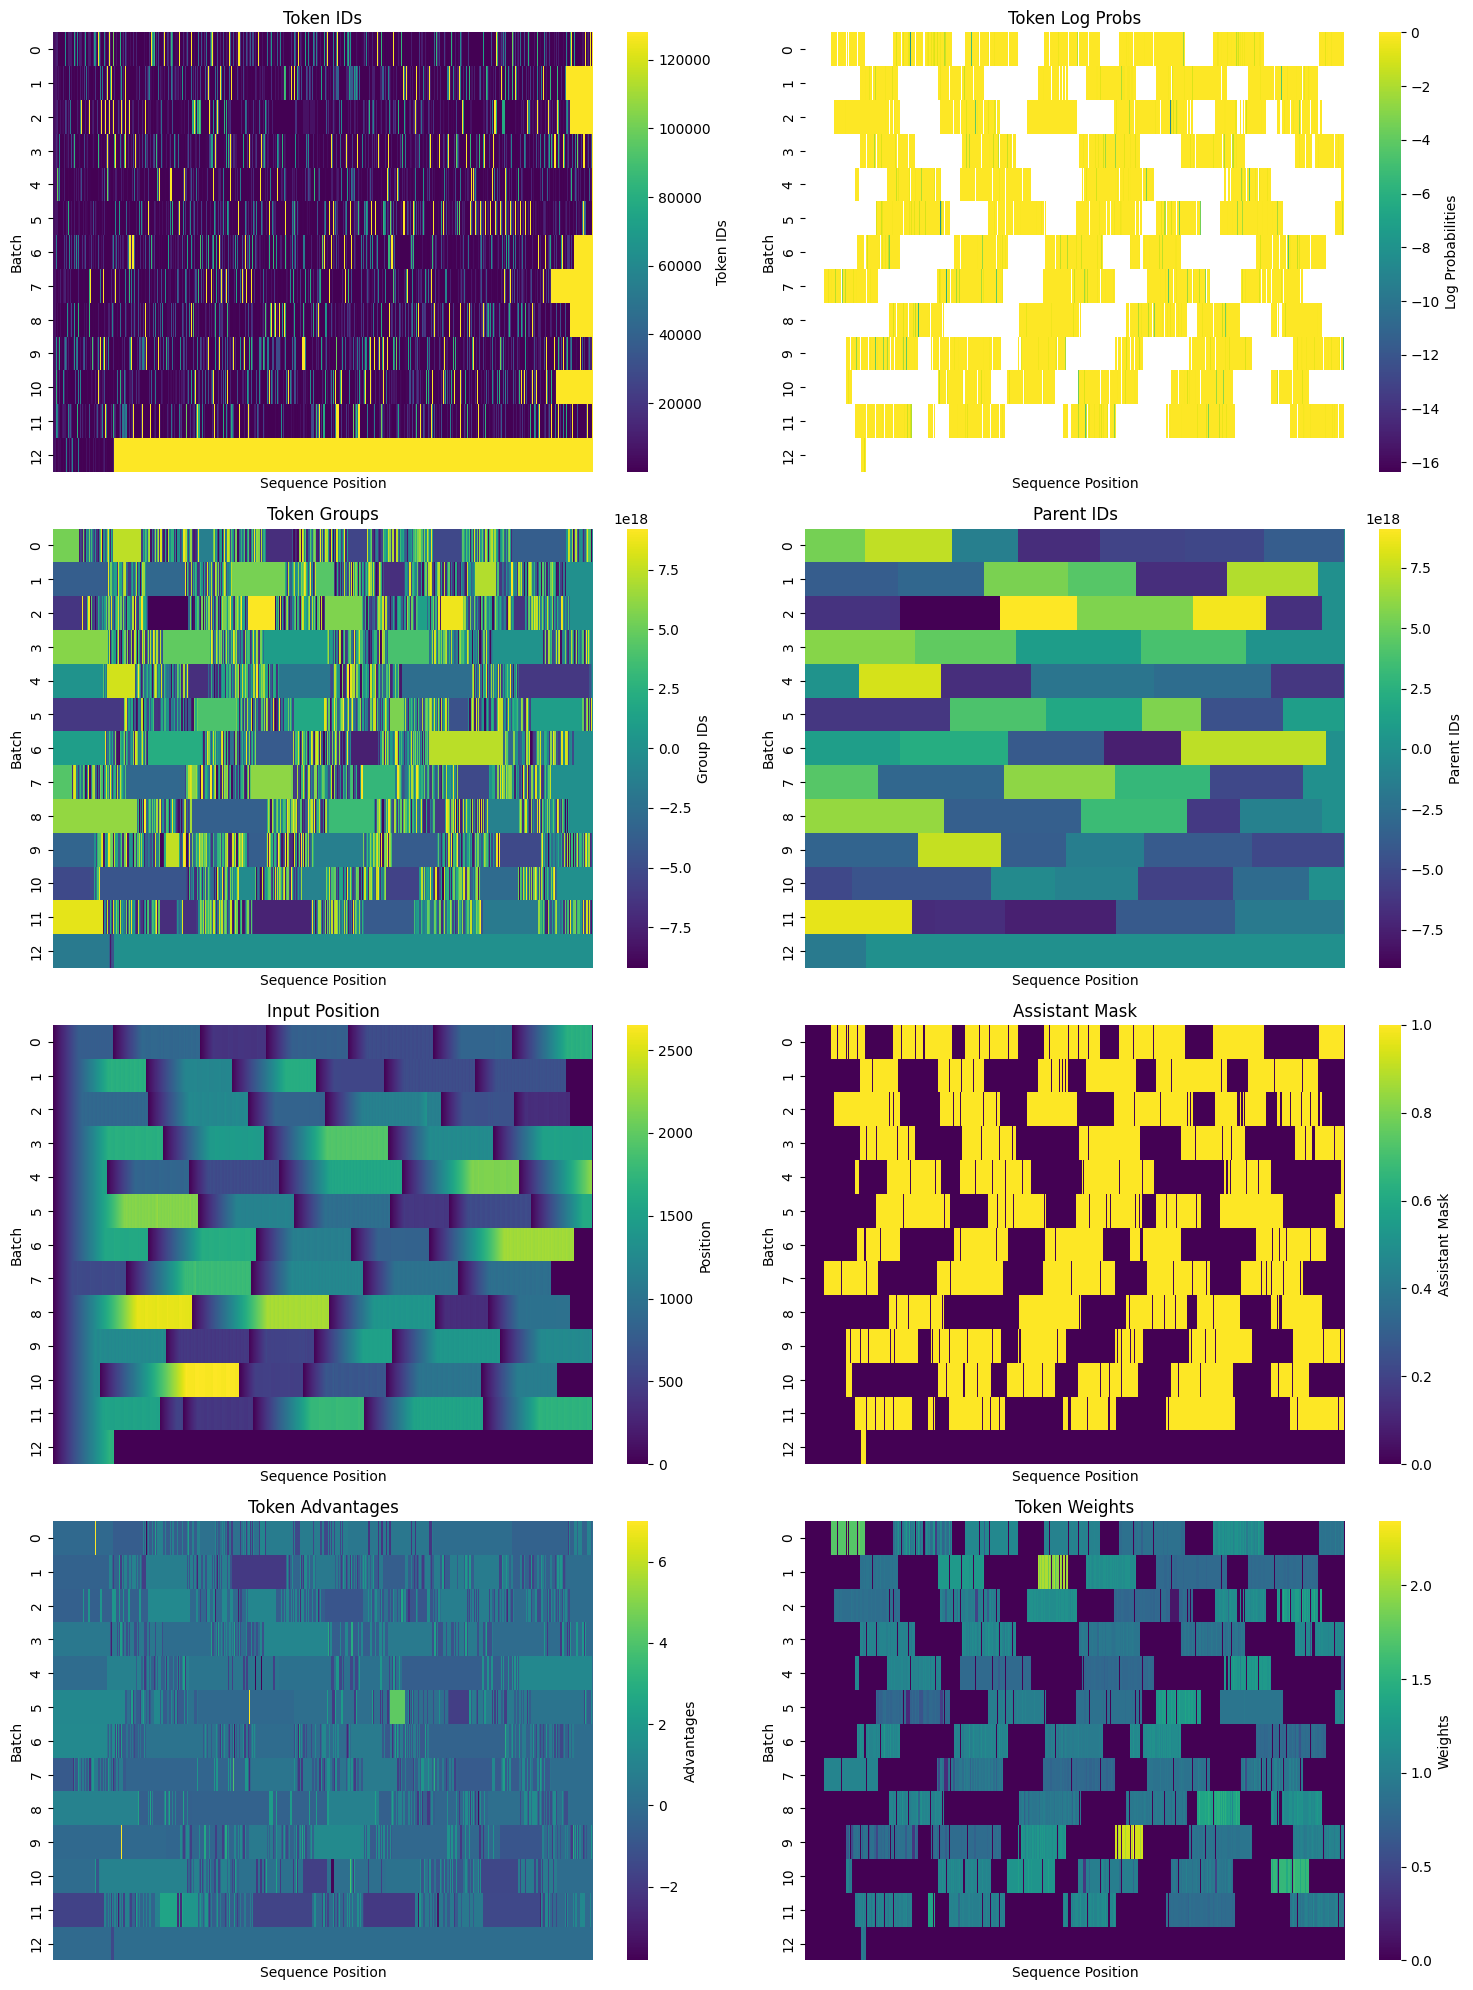

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0004
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740077091.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.36 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0021: 100%|██████████| 6/6 [02:11<00:00, 20.76s/it, entropy=0.0969, kl_div=nan, loss=-0.00208, policy=-0.00208]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.01 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #5 model files to ./models/022/0005
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0005 --port=8001 --api-key=default
INFO 02-20 18:47:58 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:47:59 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:47:59 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0005', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:10,  3.33s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.31s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.26s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.26s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.64s/it]



INFO 02-20 18:48:21 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:48:22 worker.py:267] Memory profiling takes 0.95 seconds
INFO 02-20 18:48:22 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:48:22 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:48:22 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:48:22 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:49:09 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.41 seconds
INFO 02-20 18:49:10 api_server.py:756] Using supplied chat template:
INFO 02-20 18:49:10 api_server.py:756] None
INFO 02-20 18:49:10 launcher.py:21] Available routes are:
INFO 02-20 18:49:10 launcher.py:29] Route: /

INFO:     Started server process [64660]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:49:14 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45542 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0004


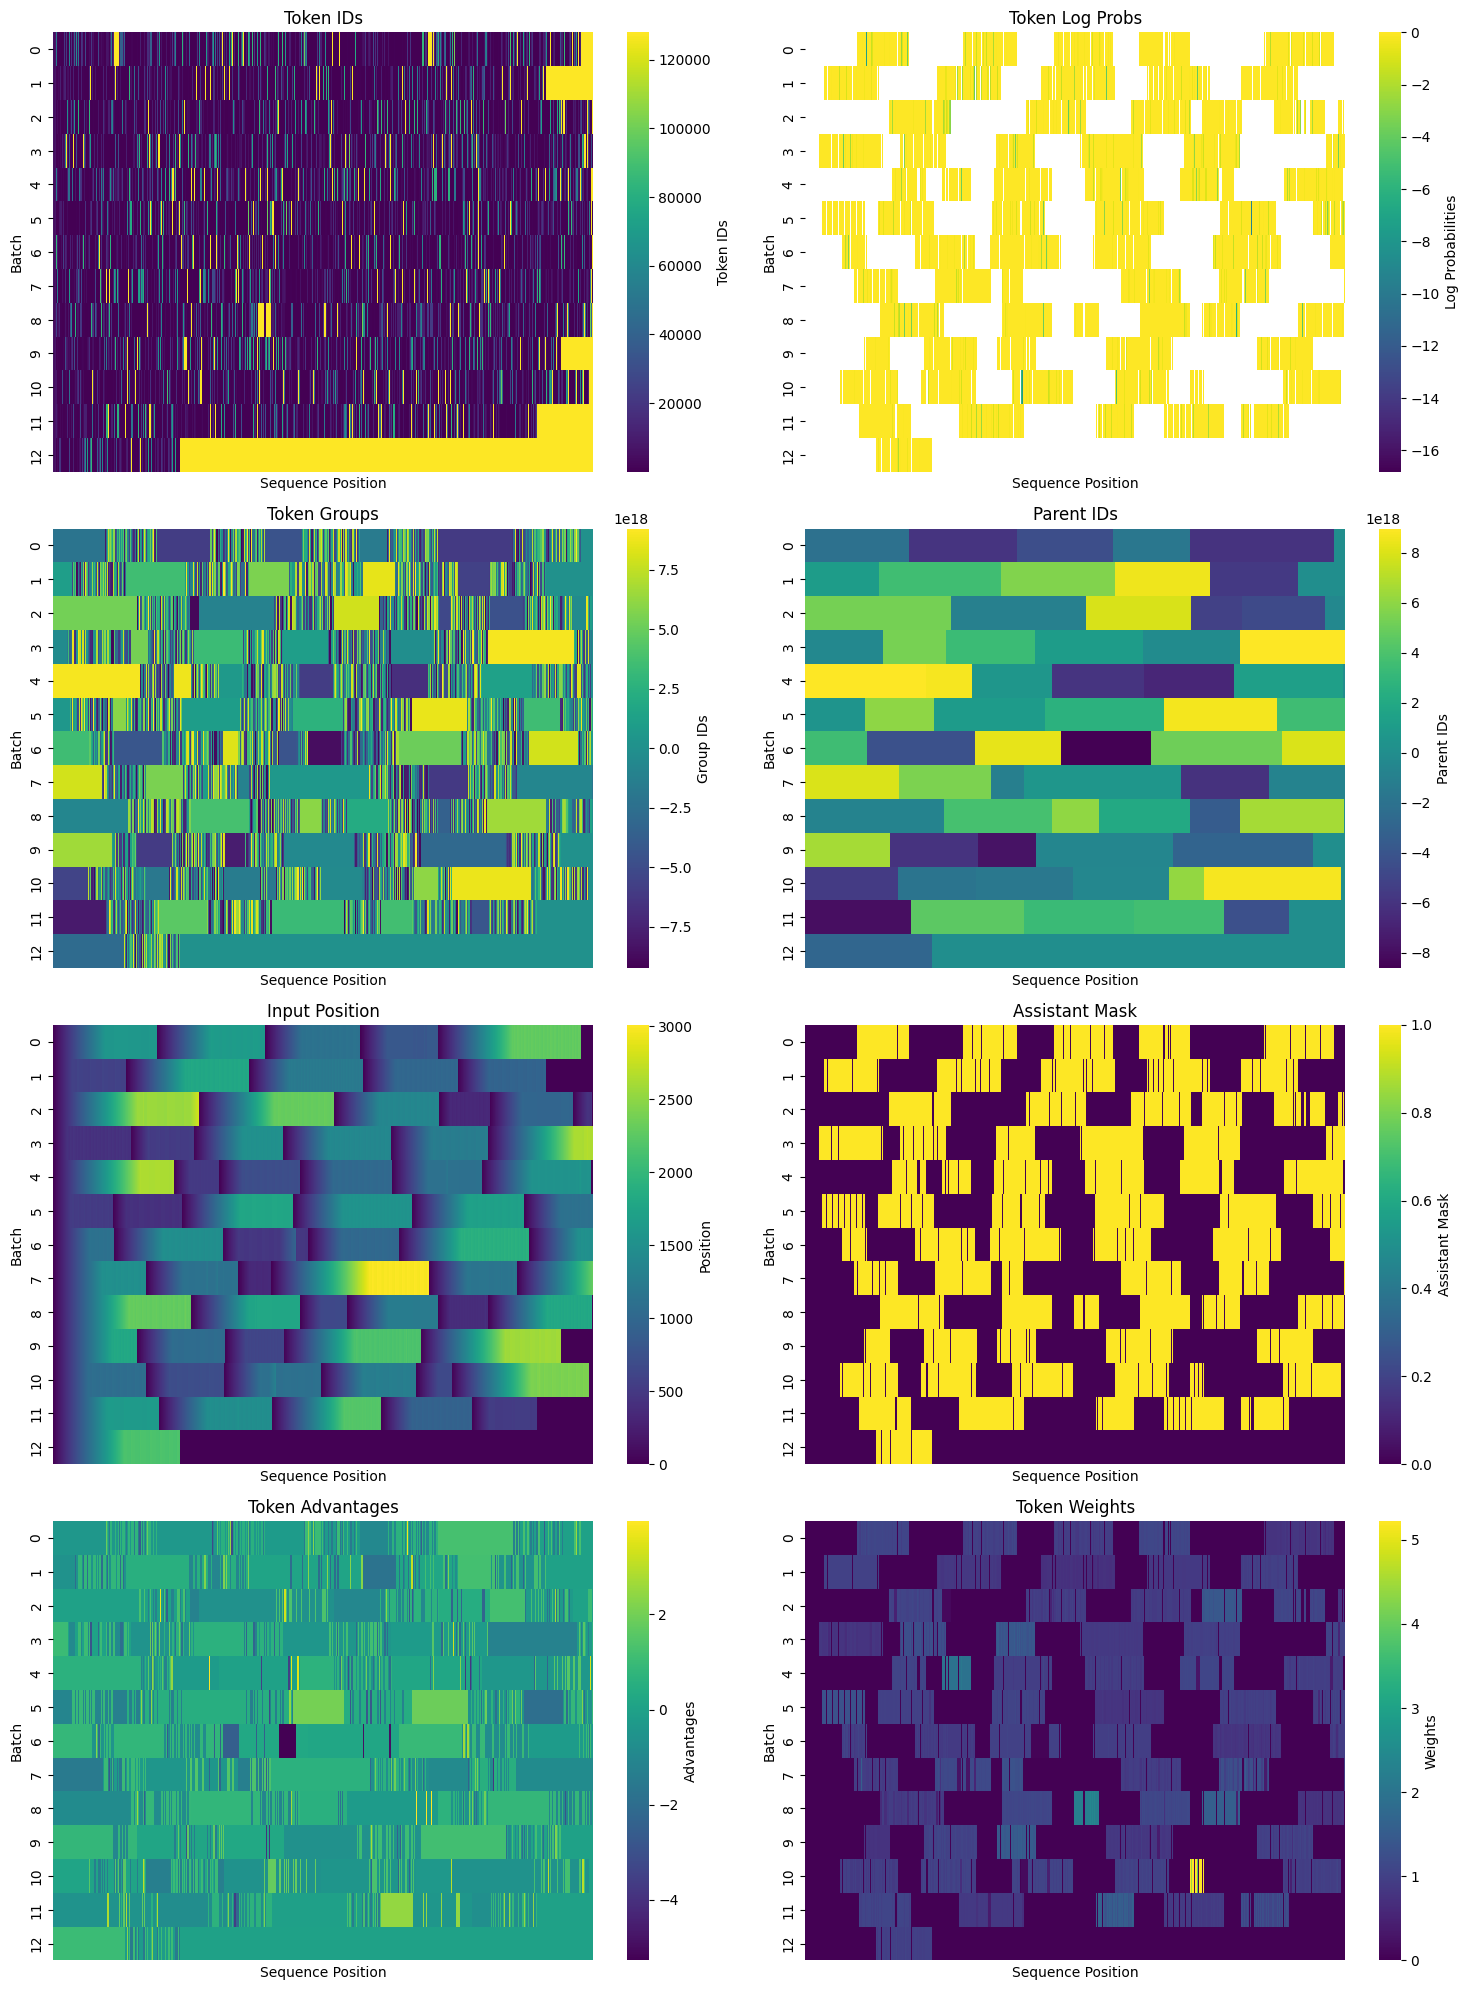

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0005
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740077484.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.56 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0006: 100%|██████████| 6/6 [02:11<00:00, 20.73s/it, entropy=0.0895, kl_div=nan, loss=-0.000626, policy=-0.000626]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.99 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #6 model files to ./models/022/0006
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0006 --port=8001 --api-key=default
INFO 02-20 18:54:31 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 18:54:32 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 18:54:32 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0006', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.33s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.33s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.29s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.29s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.67s/it]



INFO 02-20 18:54:54 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 18:54:55 worker.py:267] Memory profiling takes 0.91 seconds
INFO 02-20 18:54:55 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 18:54:55 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 18:54:55 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 18:54:55 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 18:55:42 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.20 seconds
INFO 02-20 18:55:43 api_server.py:756] Using supplied chat template:
INFO 02-20 18:55:43 api_server.py:756] None
INFO 02-20 18:55:43 launcher.py:21] Available routes are:
INFO 02-20 18:55:43 launcher.py:29] Route: /

INFO:     Started server process [67874]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 18:55:44 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38462 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0005


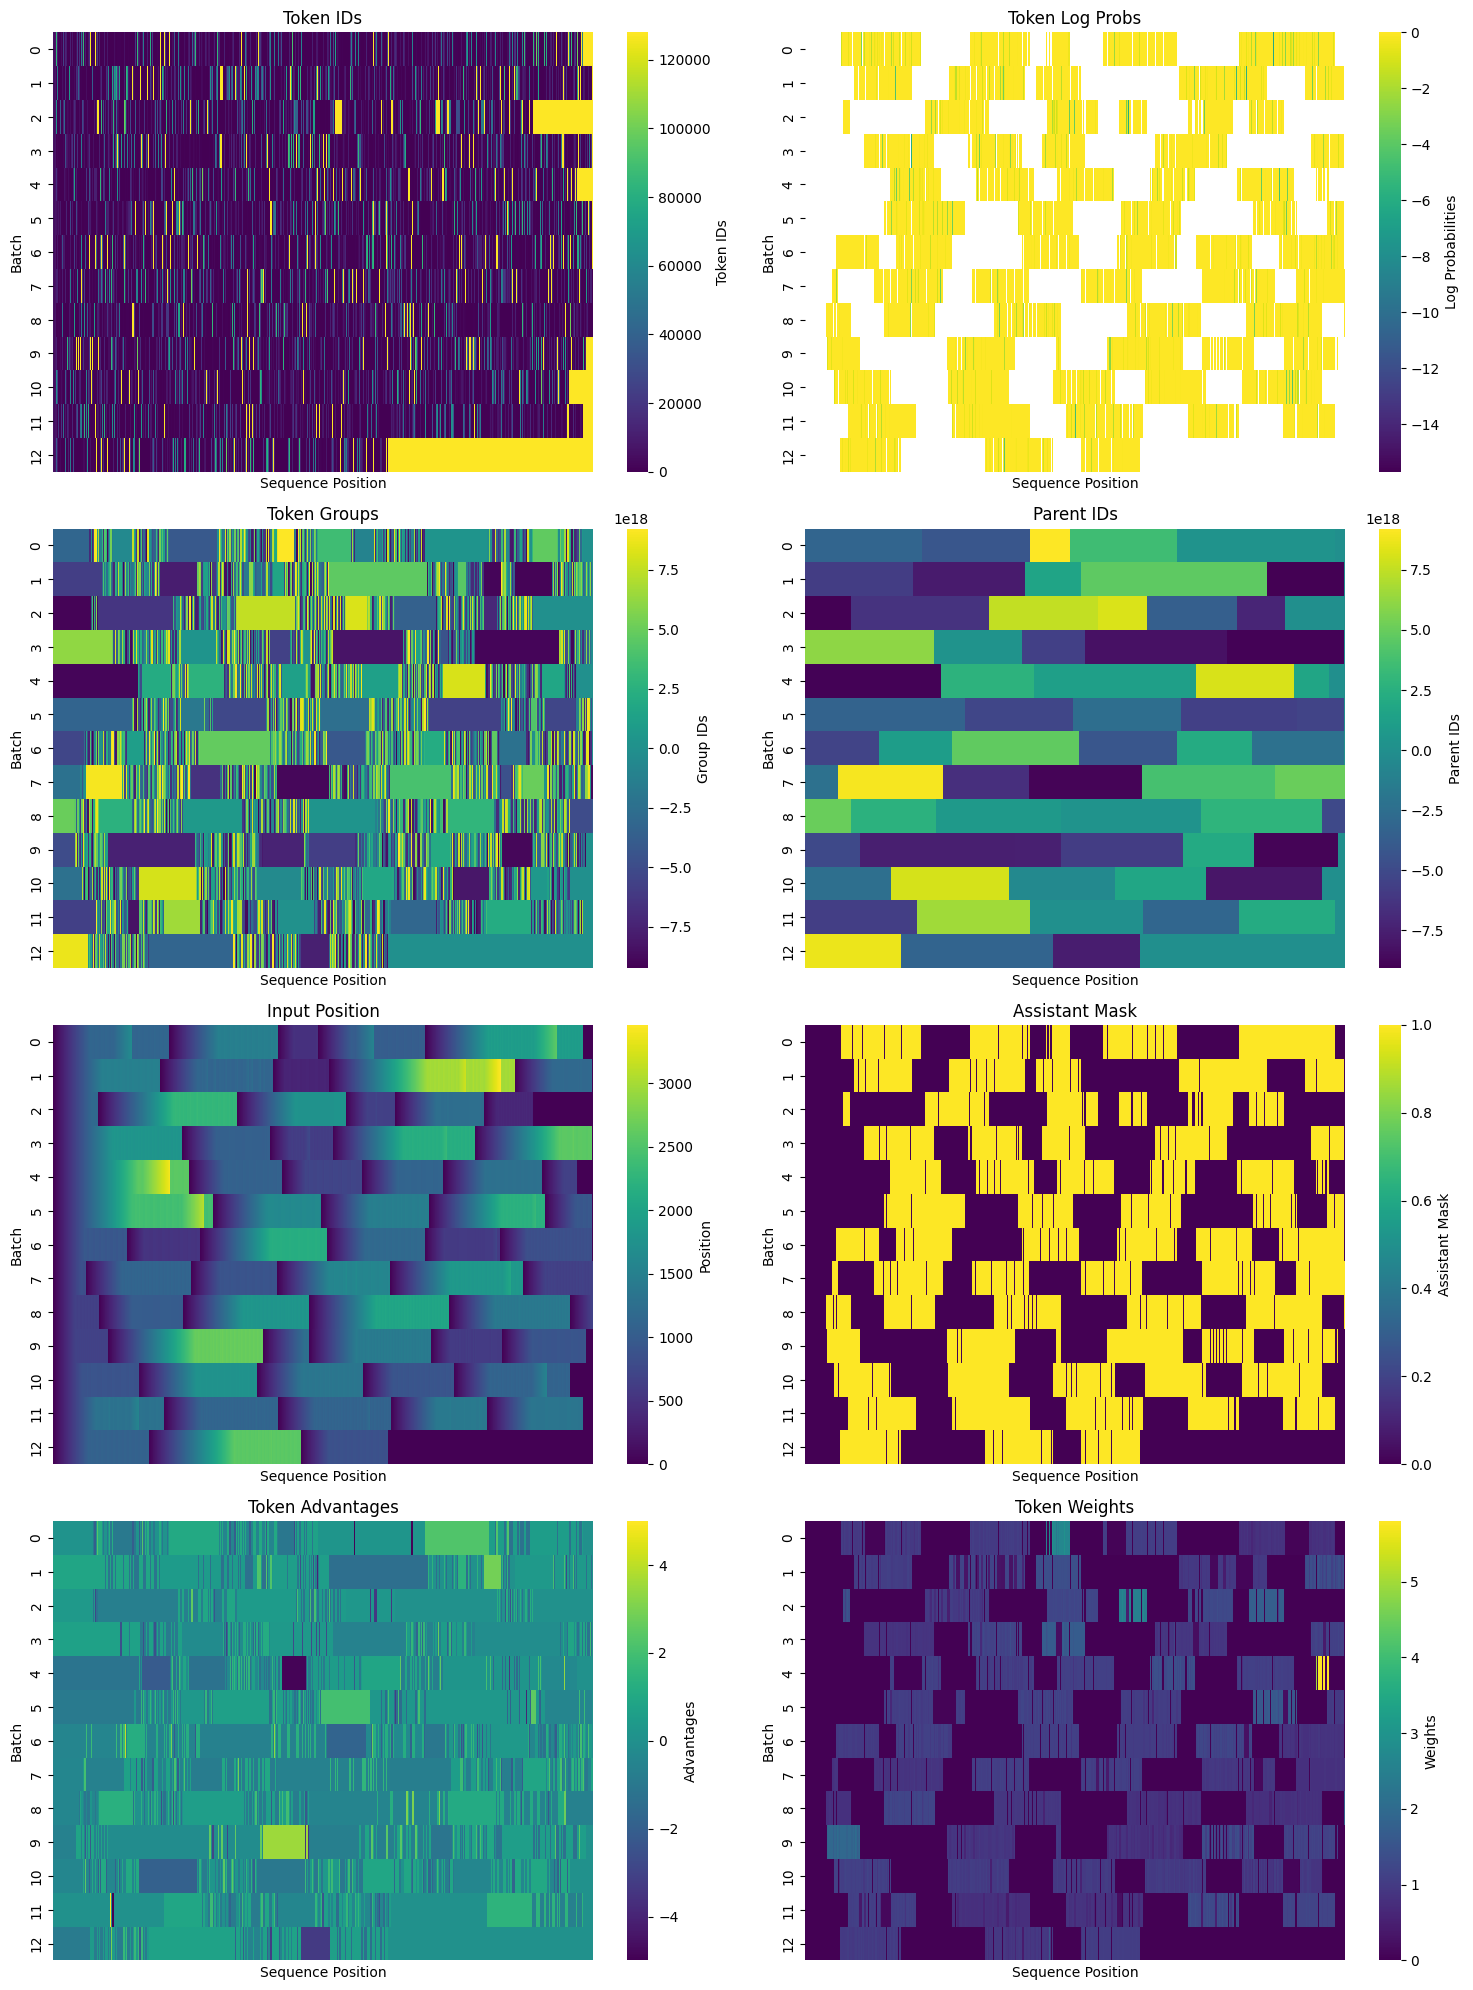

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0006
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740077888.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.64 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0018: 100%|██████████| 6/6 [02:11<00:00, 20.81s/it, entropy=0.0718, kl_div=nan, loss=-0.00183, policy=-0.00183]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.91 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #7 model files to ./models/022/0007
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0007 --port=8001 --api-key=default
INFO 02-20 19:01:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 19:01:16 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 19:01:16 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0007', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.29s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.31s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.27s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.65s/it]



INFO 02-20 19:01:38 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 19:01:39 worker.py:267] Memory profiling takes 0.95 seconds
INFO 02-20 19:01:39 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 19:01:39 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 19:01:39 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 19:01:39 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 19:02:27 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.60 seconds
INFO 02-20 19:02:28 api_server.py:756] Using supplied chat template:
INFO 02-20 19:02:28 api_server.py:756] None
INFO 02-20 19:02:28 launcher.py:21] Available routes are:
INFO 02-20 19:02:28 launcher.py:29] Route: /

INFO:     Started server process [70834]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 19:02:28 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44880 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0006


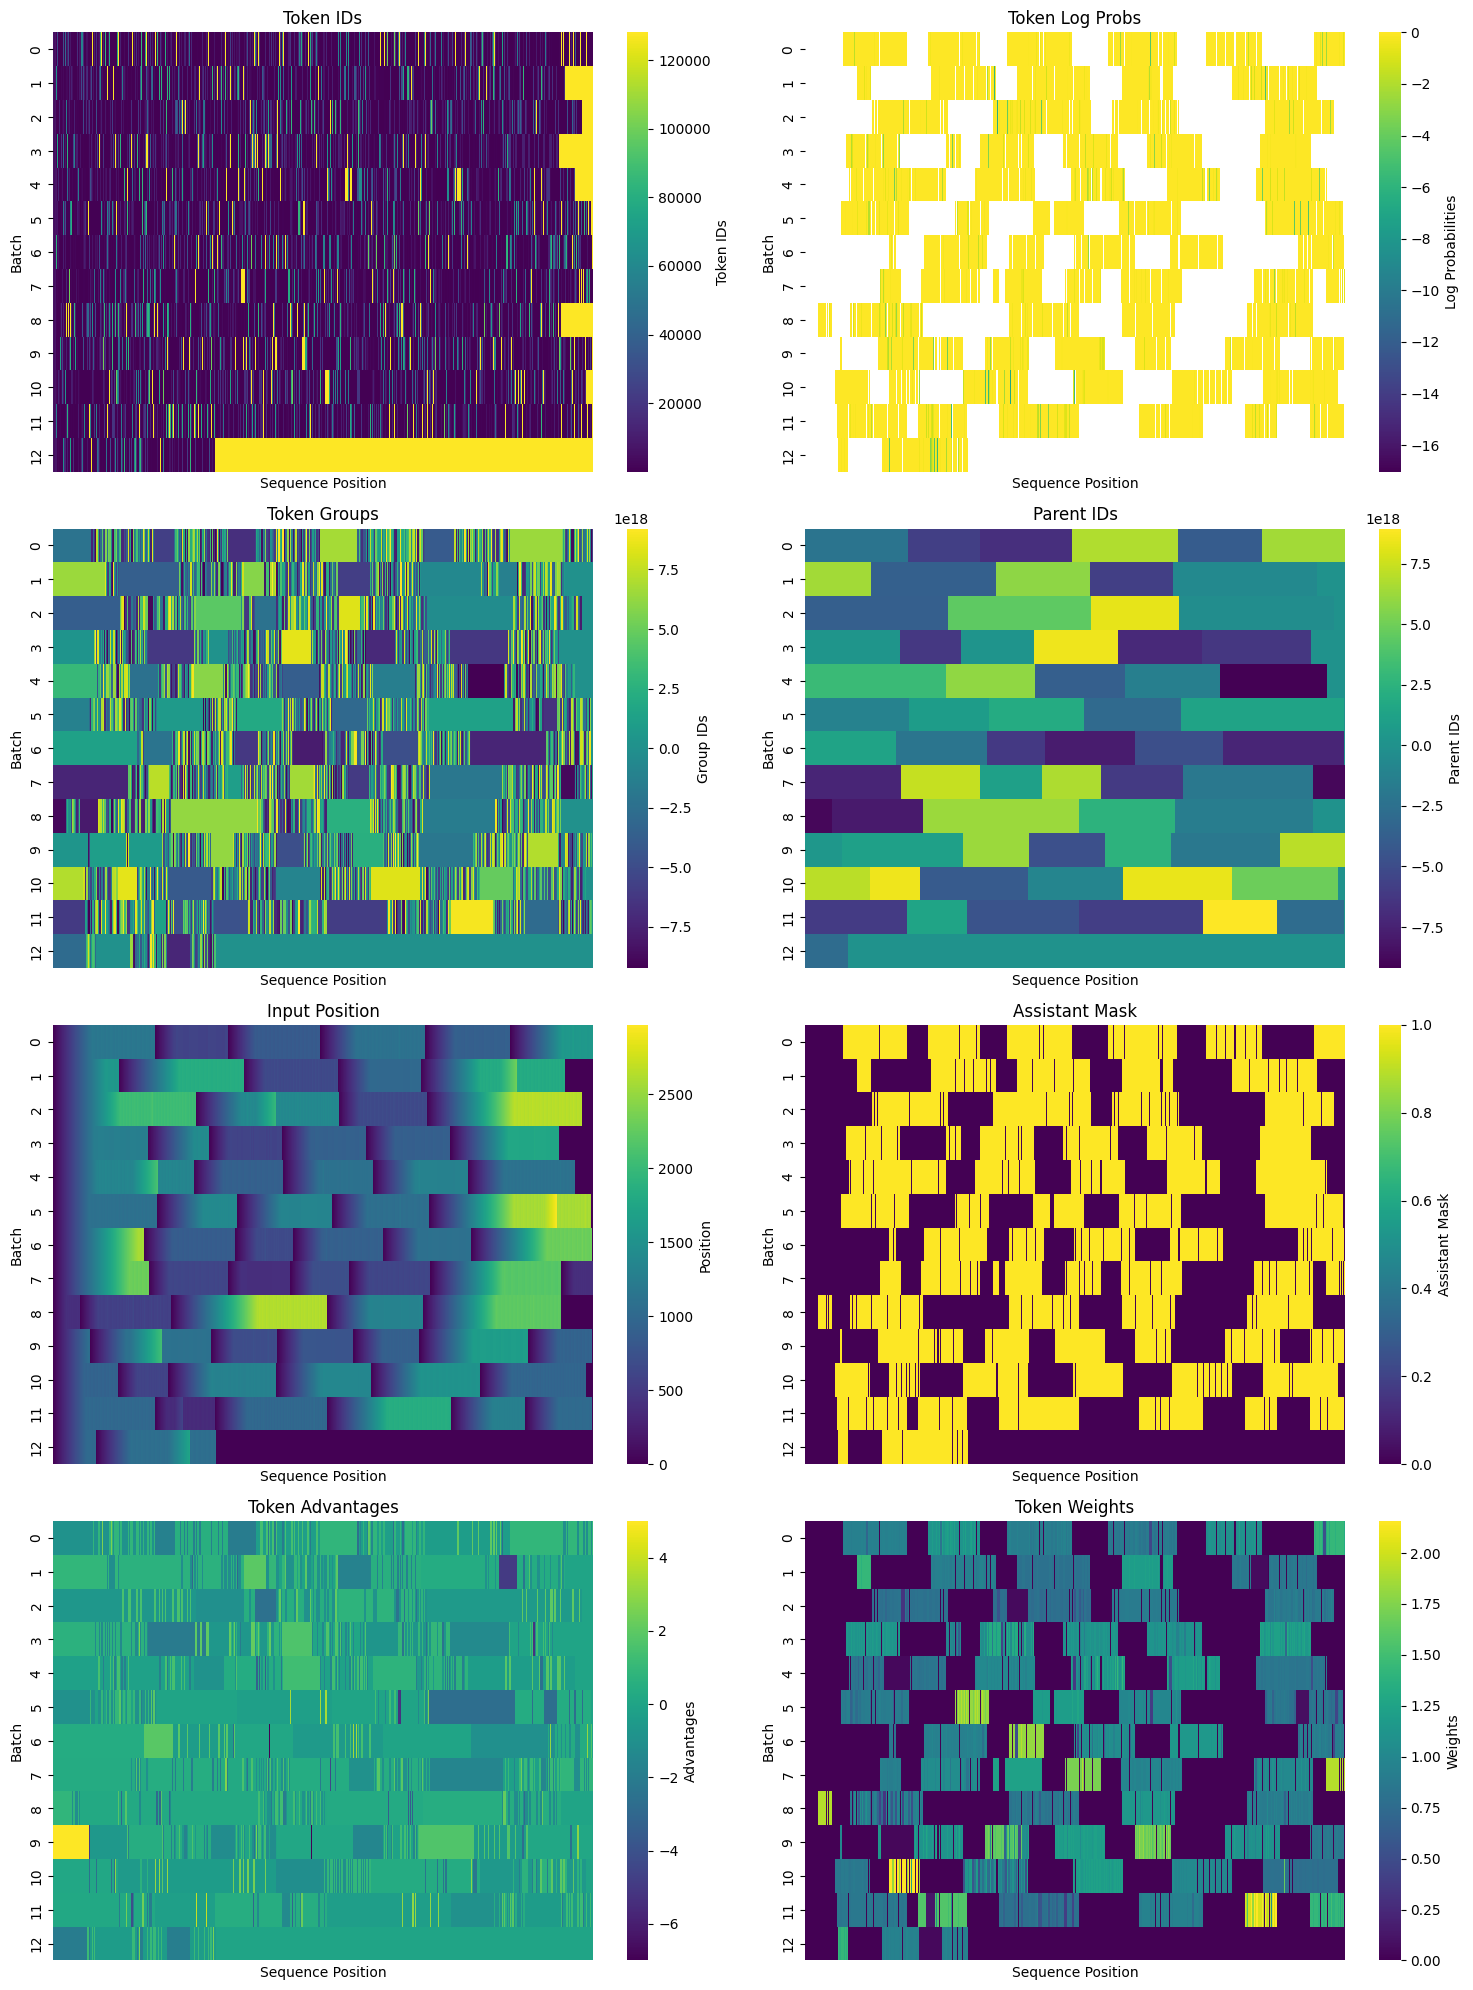

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0007
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740078273.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.56 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0006: 100%|██████████| 6/6 [02:11<00:00, 20.75s/it, entropy=0.0701, kl_div=nan, loss=-0.000623, policy=-0.000623]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.96 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #8 model files to ./models/022/0008
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0008 --port=8001 --api-key=default
INFO 02-20 19:07:40 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 19:07:41 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 19:07:41 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0008', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.31s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.31s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.29s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.66s/it]



INFO 02-20 19:08:03 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 19:08:04 worker.py:267] Memory profiling takes 0.90 seconds
INFO 02-20 19:08:04 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 19:08:04 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 19:08:04 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 19:08:04 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 19:08:51 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.48 seconds
INFO 02-20 19:08:52 api_server.py:756] Using supplied chat template:
INFO 02-20 19:08:52 api_server.py:756] None
INFO 02-20 19:08:52 launcher.py:21] Available routes are:
INFO 02-20 19:08:52 launcher.py:29] Route: /

INFO:     Started server process [74016]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 19:08:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55844 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

ZeroDivisionError: division by zero

In [31]:
model_name = get_model_name(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = (i - 1) * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    vllm.process.terminate()
    kill_vllm_workers()
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i - 1])
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0008 --port=8001 --api-key=default
INFO 02-20 19:20:01 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 19:20:02 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 19:20:02 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0008', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:09,  3.32s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.32s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.27s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.65s/it]



INFO 02-20 19:20:24 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 19:20:25 worker.py:267] Memory profiling takes 0.92 seconds
INFO 02-20 19:20:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 19:20:25 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 19:20:25 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 19:20:25 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 19:21:12 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.40 seconds
INFO 02-20 19:21:13 api_server.py:756] Using supplied chat template:
INFO 02-20 19:21:13 api_server.py:756] None
INFO 02-20 19:21:13 launcher.py:21] Available routes are:
INFO 02-20 19:21:13 launcher.py:29] Route: /

INFO:     Started server process [79063]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 19:21:18 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-20 19:21:18 metrics.py:455] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-20 19:21:18 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:47888 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

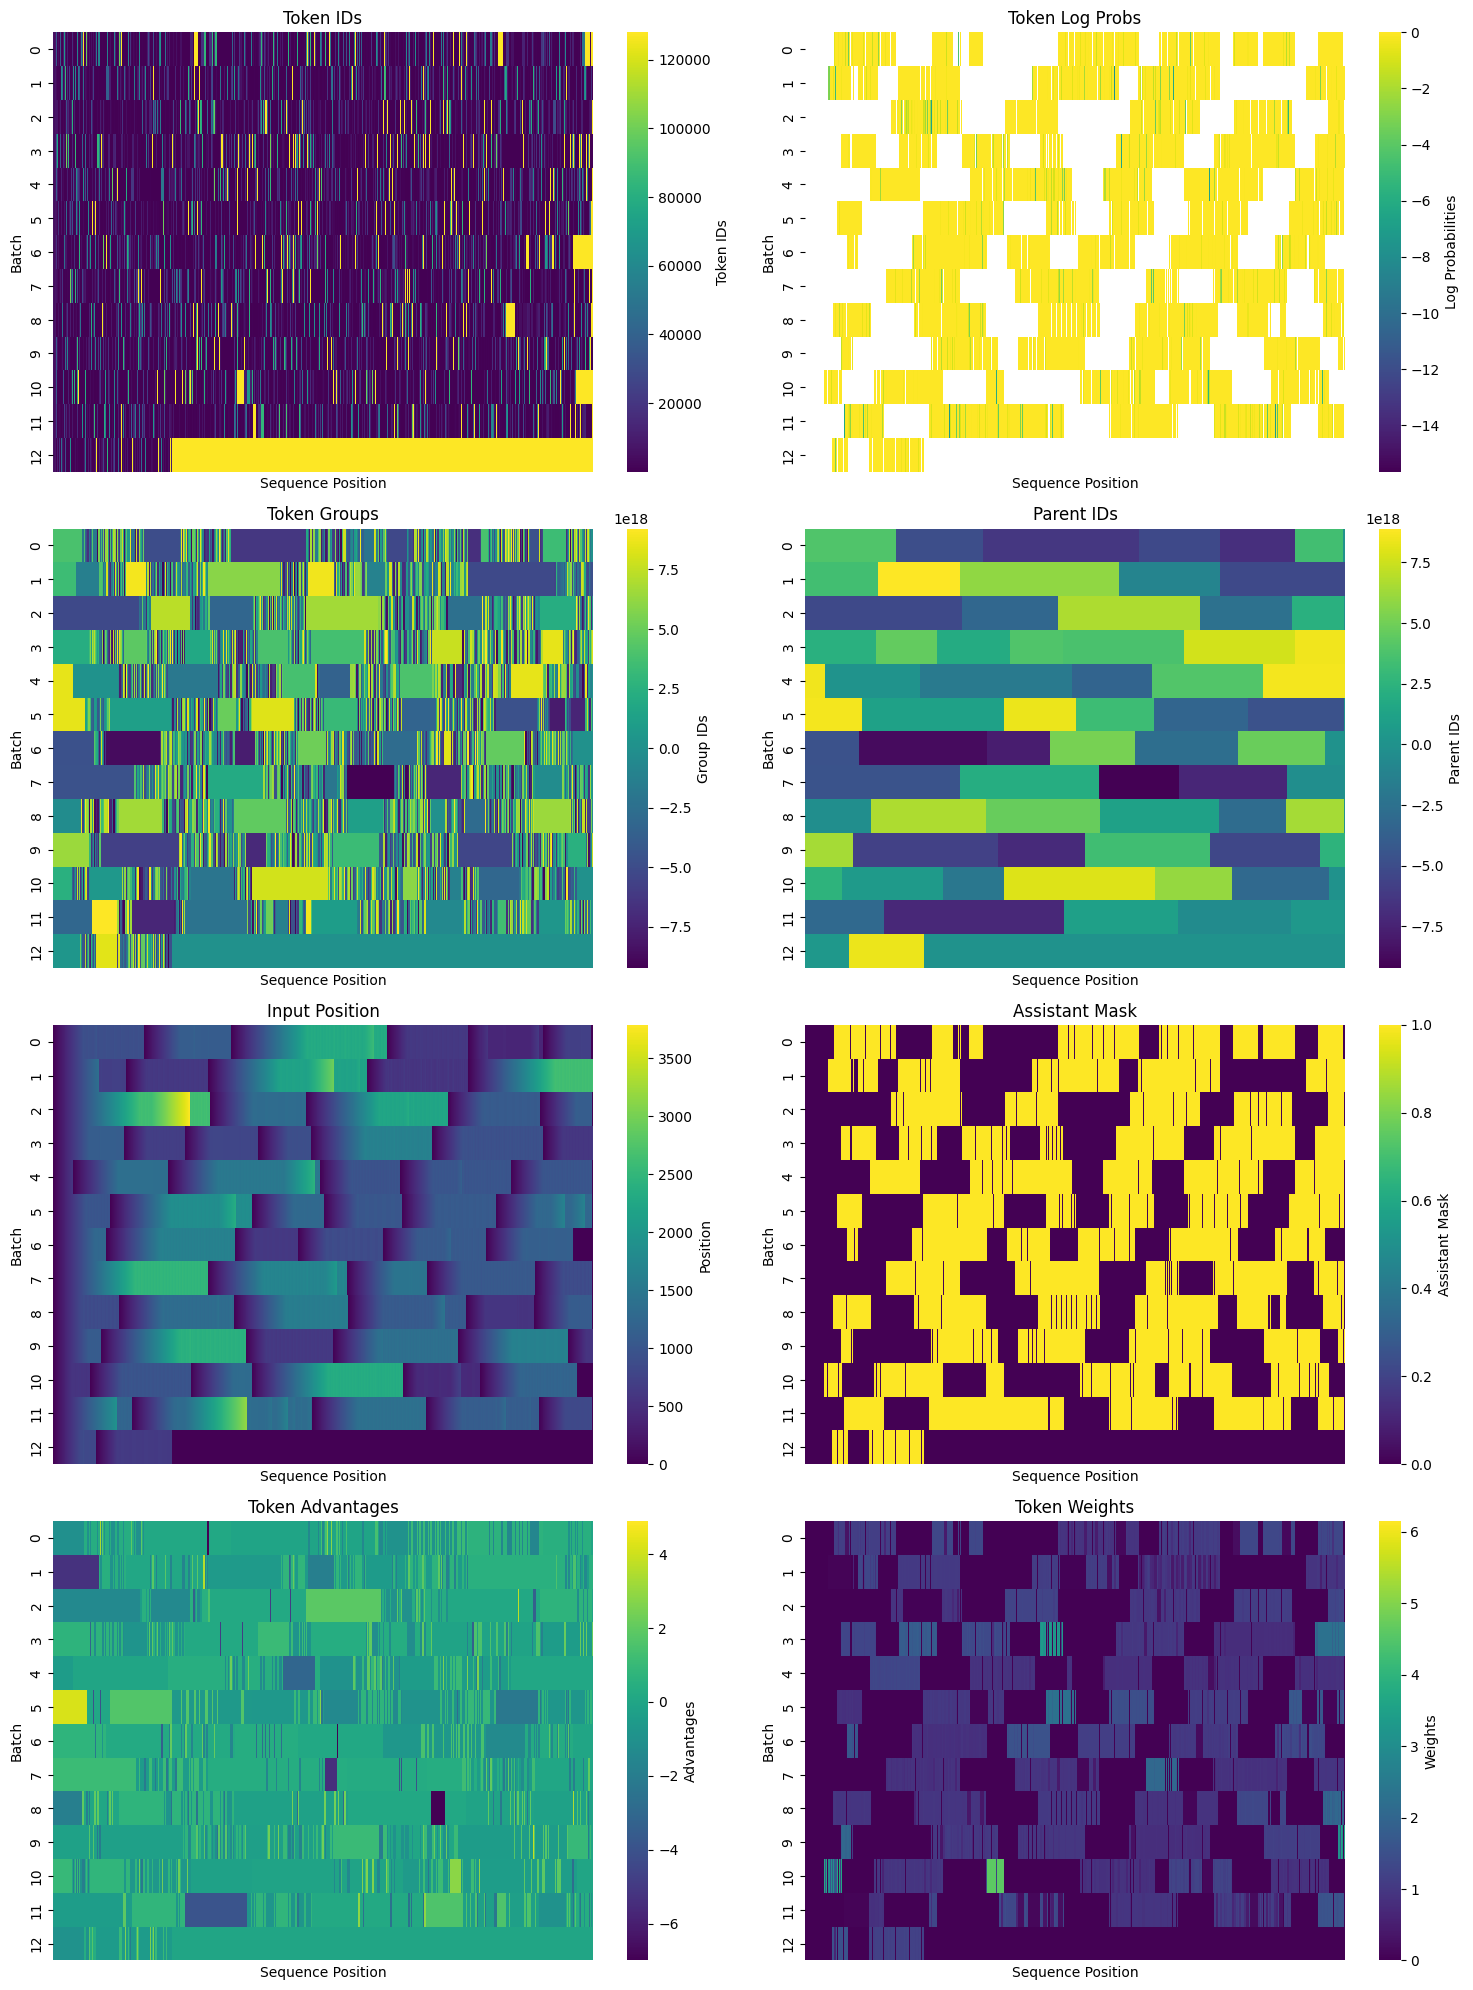

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0008
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740079447.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.84 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0205: 100%|██████████| 6/6 [02:12<00:00, 20.80s/it, entropy=0.0547, kl_div=nan, loss=-0.0205, policy=-0.0205]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.97 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #9 model files to ./models/022/0009
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/022/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/022/0009 --port=8001 --api-key=default
INFO 02-20 19:27:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 19:27:16 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 19:27:16 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/022/0009', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:03<00:10,  3.33s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.33s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.30s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.66s/it]



INFO 02-20 19:27:38 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-20 19:27:39 worker.py:267] Memory profiling takes 0.96 seconds
INFO 02-20 19:27:39 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 19:27:39 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-20 19:27:39 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-20 19:27:39 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-20 19:28:27 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.59 seconds
INFO 02-20 19:28:27 api_server.py:756] Using supplied chat template:
INFO 02-20 19:28:27 api_server.py:756] None
INFO 02-20 19:28:27 launcher.py:21] Available routes are:
INFO 02-20 19:28:27 launcher.py:29] Route: /

INFO:     Started server process [82609]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 19:28:33 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-20 19:28:33 metrics.py:455] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-20 19:28:33 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:41446 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Deleted iteration directory ./models/022/0008


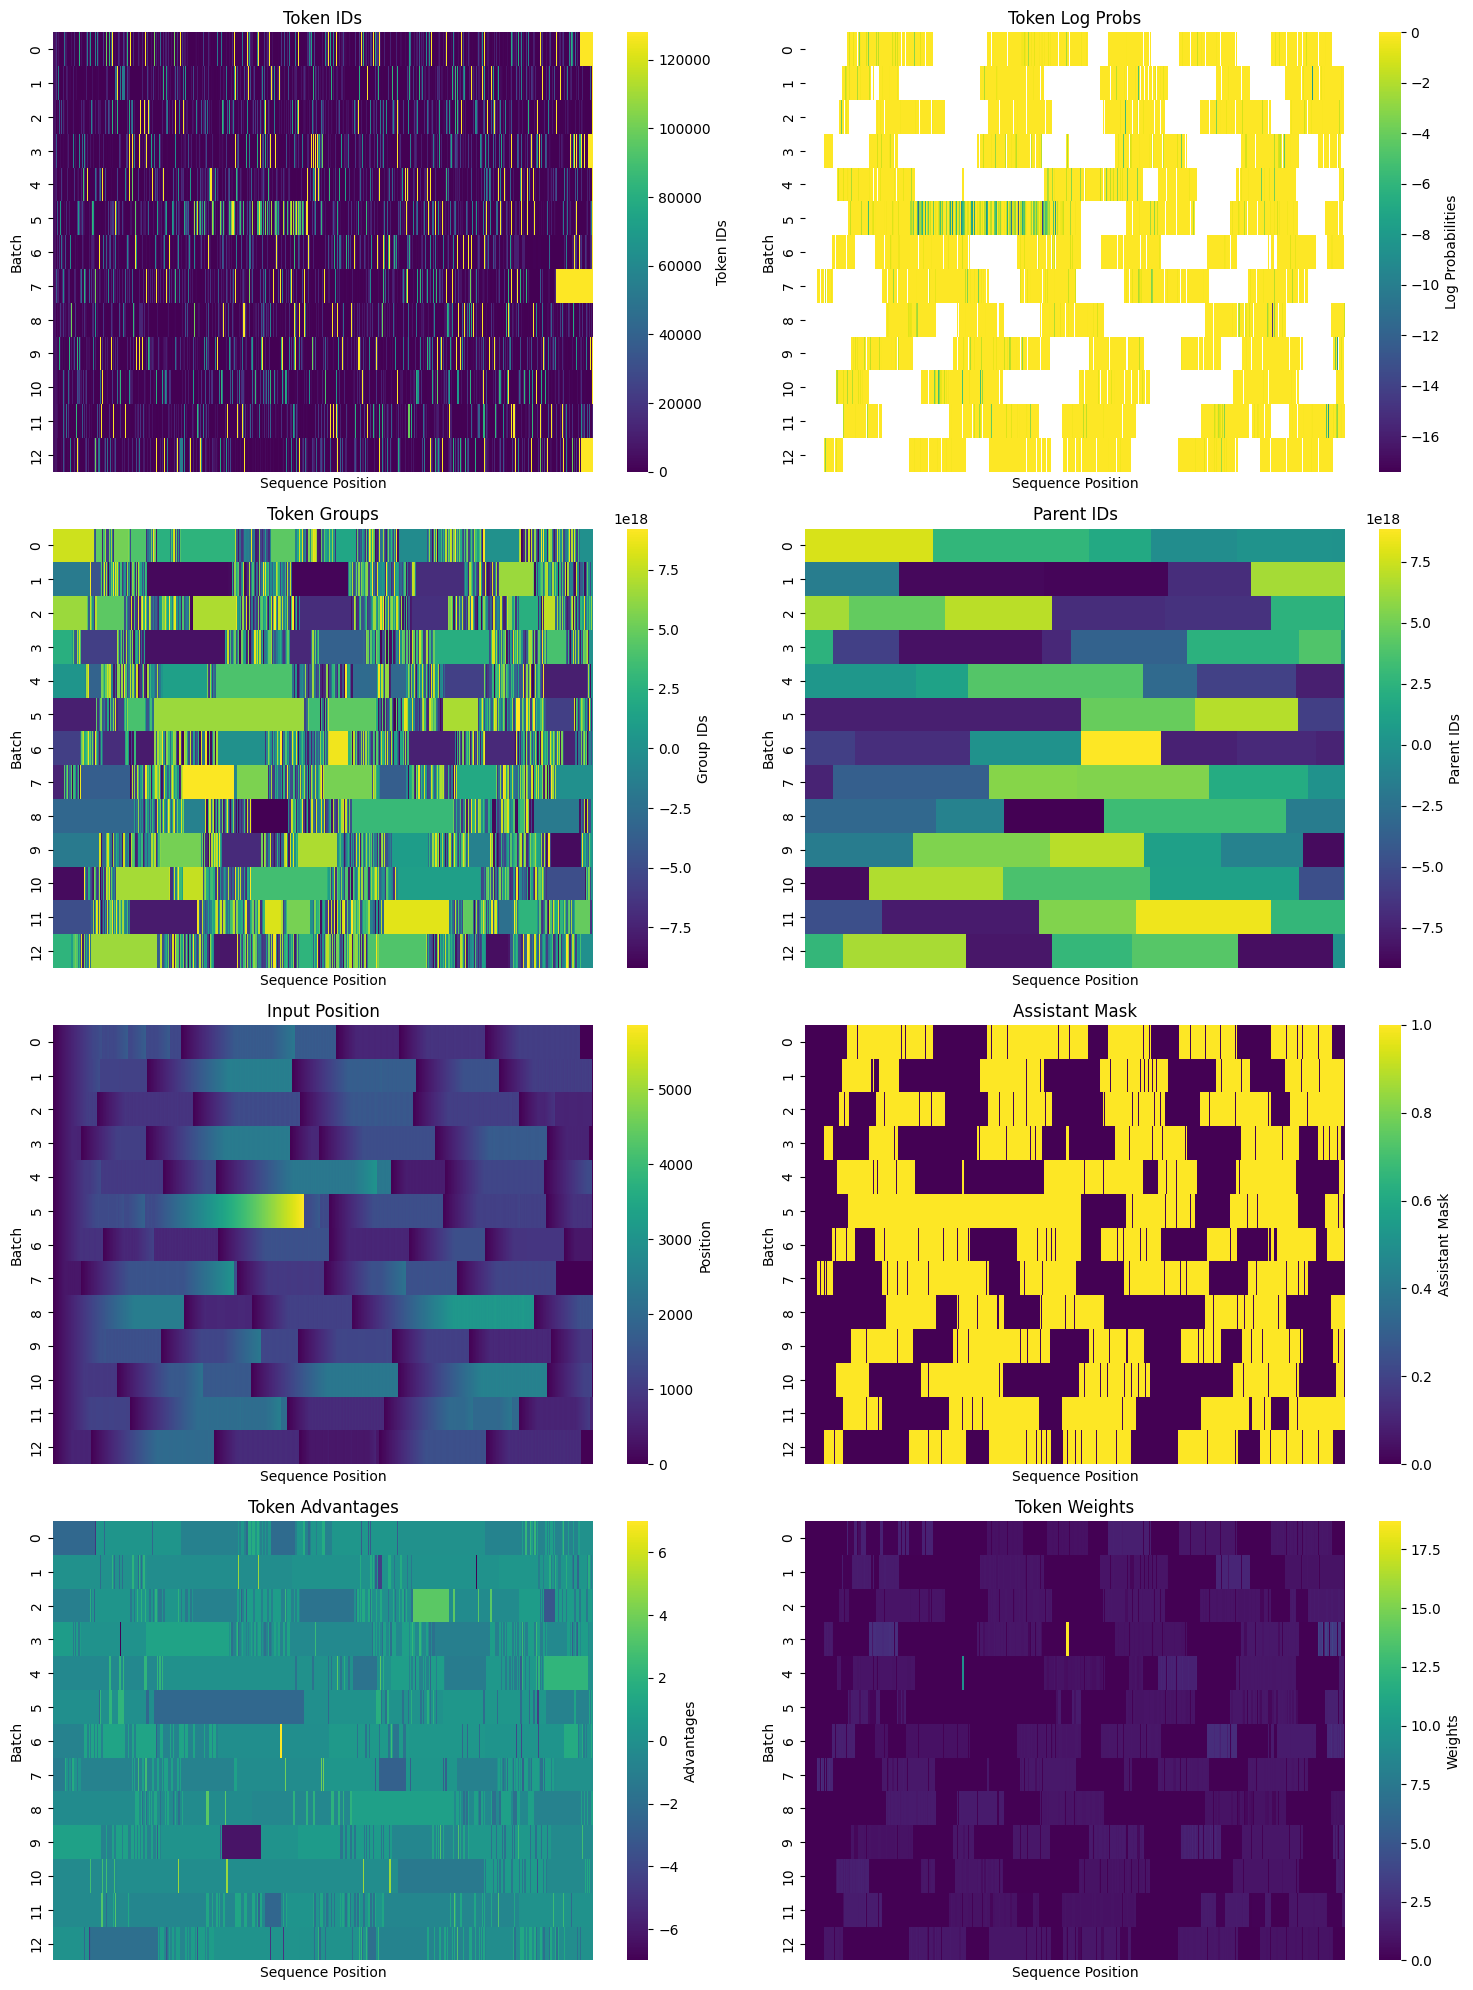

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/022/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/022/0009
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  model_type: LLAMA3
  output_dir: ./models/022
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/022/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/022/logs/log_1740079870.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.60 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: -0.0051: 100%|██████████| 6/6 [02:11<00:00, 20.75s/it, entropy=0.066, kl_div=nan, loss=-0.00506, policy=-0.00506]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.89 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #10 model files to ./models/022/0010


entropy,█▂▁▁▁▁▁▁▁▁
exceptions,▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▂▃▃▄▅▆▆▇▇█
loss,█▄▇█▆▅▁▇▇▃
policy,█▄▇█▆▅▁▇▇▃
reward,▁▄▆▆▆▇█▇█▇▇
tokens,█▁▁▁▁▁▁▁▁▁▁
tokens_per_second_per_gpu,█▂▂▂▁▁▂▂▂▂
entropy,0.07921
exceptions,0
iteration,10


In [32]:
model_name = get_model_name(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = (i - 1) * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    vllm.process.terminate()
    kill_vllm_workers()
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i - 1])
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()